# Домашнее задание к занятию “Архитектуры свёрточных сетей”

Задание
Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

* Возьмите датасет EMNIST из torchvision
* Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)
* Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.


Инструкция к выполнению задания

* Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
* Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
* Обучите модель с нуля 10 эпох. Фиксируйте значение функции потерь в список для последующего отображения.
* Повторите пункты 2 и 3 для всех указанных вариантов моделей.


### импорт библиотек

In [ ]:
import torch
import pandas as pd
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torchvision.models import Inception_V3_Weights
from torchvision.models import DenseNet161_Weights
from torchvision.models import VGG16_Weights


### загрузка данных EMNIST

In [ ]:
BATCH_SIZE = 256

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split = 'letters', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split = 'letters', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
print(f'Data size:\n\t train {len(train_dataset)},\n\t test {len(test_dataset)}')
print(f'Data shape:\n\t features {train_dataset[0][0].shape},\n\t target {type(test_dataset[0][1])}')

Data size:
	 train 124800,
	 test 20800
Data shape:
	 features torch.Size([3, 224, 224]),
	 target <class 'int'>


In [ ]:
x_batch, y_batch = next(iter(train_iter))
x_batch.shape, y_batch.shape

(torch.Size([256, 3, 224, 224]), torch.Size([256]))

In [ ]:
# функция создает датасет с распределением классов
def loads_labels(dataset):
    labels = []
    for i in dataset:
        labels.append(i[1])
    counts = Counter(labels)
    count_df =  pd.DataFrame([(k, v) for k, v in counts.items()],
    columns=['class', 'count'])
    return count_df.sort_values(by = 'class')

In [ ]:
train_labels = loads_labels(train_dataset)
train_labels

,class,count
20,1,4800
16,2,4800
23,3,4800
22,4,4800
15,5,4800
25,6,4800
1,7,4800
21,8,4800
18,9,4800
9,10,4800


In [ ]:
test_labels = loads_labels(test_dataset)
test_labels

,class,count
0,1,800
1,2,800
2,3,800
3,4,800
4,5,800
5,6,800
6,7,800
7,8,800
8,9,800
9,10,800


ВЫВОД: имеем 26 классов. Классы сбалансированы.

23


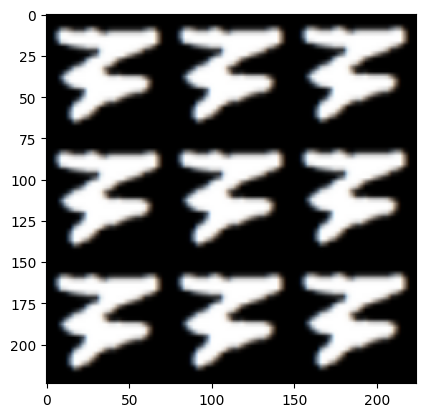

In [ ]:
image, label = next(iter(train_dataset))
plt.imshow(image.squeeze().numpy().reshape(224,224, 3), cmap="gray")
print(label)

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 3, 224, 224]) torch.Size([10])


labels:  23, 7, 16, 15, 23, 17, 13, 11, 22, 24, 

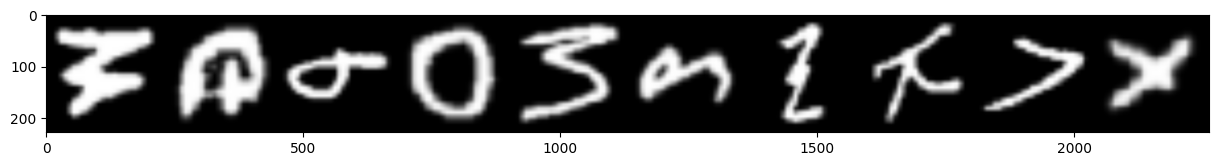

In [ ]:
grid = tv.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(label.numpy(), end=", ")

### функции для обучения и теста

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n, test_loss_sum = 0, 0, 0
    net.eval()
    loss = nn.CrossEntropyLoss(reduction='sum')

    for X, y in data_iter:
        y = y-1
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        test_loss_sum += l.item()
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    acc = acc_sum.item() / n
    test_loss = test_loss_sum / n
    return acc, test_loss

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    history_l_train = []
    history_acc_train = []
    history_l_test = []
    history_acc_test = []
    history_l_e_train = []

    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            y = y - 1
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {(train_acc_sum / n)*100:.3f}%. Train Loss: {train_l_sum / n:.3f}")
            history_l_train.append(train_l_sum / n) # сохранение тренировочного лосса в список для визуализации
            # history_acc_train.append(train_acc_sum / n) # сохранение тренировочного accuracy в список

        test_acc, test_loss = evaluate_accuracy(test_iter, net.to(device))
        test_acc = round(test_acc*100, 3)

        history_l_e_train.append(train_l_sum / n) # сохранение тренировочного лосса в список для визуализации
        history_acc_test.append(test_acc) # сохранение тестового accuracy
        history_l_test.append(test_loss) # сохранение тестового loss


        print('-' * 20)
        print(f'epoch {epoch + 1}, loss_train {train_l_sum / n:.4f}, train acc {(train_acc_sum / n)*100:.3f}%'
              f', loss_test { test_loss:.4f}, test acc {test_acc}%, time {time.time() - start:.1f} sec')
        print('-' * 60)

    return history_l_train, history_l_e_train, history_l_test, history_acc_test

In [ ]:
epoch = 10

### ResNet 18

In [ ]:
model_resnet = tv.models.resnet18(pretrained=True)
model_resnet

In [ ]:
summary(model_resnet.to(device), input_size=(3, 224, 224))

In [ ]:
def use_model(model):
    # Убираем требование градиента:
    for param in model.parameters():
        param.requires_grad = False
# заменяем  выходной слой
    model.fc = nn.Linear(in_features=512, out_features=26)

# указываем какой слой будет обучаться
    params_to_update = []
    for name, param in model.named_parameters():
        # print(param.requires_grad )
        if param.requires_grad == True:
            params_to_update.append(param)


    return model, params_to_update


In [ ]:
model, params_to_update = use_model(model_resnet)
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
loss_train_step, loss_train_ep, loss_test, acc_ResNet = train(model, train_iter, test_iter, trainer, epoch)


In [ ]:
acc_ResNet

[83.418, 84.971, 85.231, 85.51, 85.707, 85.865, 86.288, 86.409, 86.654, 86.149]

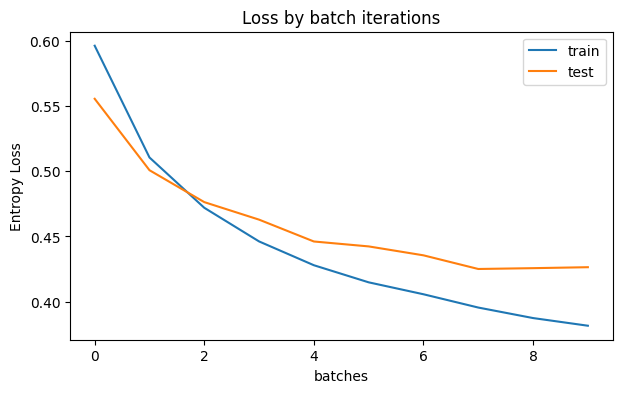

In [ ]:
# график для отображения динамики loss
plt.figure(figsize=(7, 4))

plt.plot(loss_train_ep, label = 'train')
plt.plot(loss_test, label = 'test')

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')
plt.legend()
plt.show()

### VGG 16

In [ ]:
model_vgg = tv.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model_vgg

In [ ]:
summary(model_vgg.to(device), input_size=(3, 224, 224))

In [ ]:
# Убираем требование градиента:
for param in model_vgg.parameters():
    param.requires_grad = False

In [ ]:
model_vgg.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=26)

In [ ]:
model_vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=26, bias=True)
)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
loss_train_step, loss_train_ep, loss_test, acc_VGG16 = train(model_vgg, train_iter, test_iter, trainer, epoch)

In [ ]:
# график для отображения динамики loss
plt.figure(figsize=(7, 4))

plt.plot(loss_train_ep, label = 'train')
plt.plot(loss_test, label = 'test')

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')
plt.legend()
plt.show()

### DenseNet 161

In [ ]:
model_densenet = tv.models.densenet161(weights=DenseNet161_Weights.IMAGENET1K_V1)
model_densenet

In [ ]:
# Убираем требование градиента:
for param in model_densenet.parameters():
    param.requires_grad = False

In [ ]:
model_densenet.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [ ]:
model_densenet.classifier = nn.Linear(in_features=2208, out_features=26)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model_densenet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [ ]:
# model, params_to_update = use_model(model_densenet)
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
loss_train_step, loss_train_ep, loss_test, acc_DenseNet = train(model_densenet, train_iter, test_iter, trainer, epoch)

In [ ]:
# график для отображения динамики loss
plt.figure(figsize=(7, 4))

plt.plot(loss_train_ep, label = 'train')
plt.plot(loss_test, label = 'test')

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')
plt.legend()
plt.show()

### Inception v3

In [ ]:
BATCH_SIZE = 256

In [ ]:
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split = 'letters', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split = 'letters', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
print(f'Data size:\n\t train {len(train_dataset)},\n\t test {len(test_dataset)}')
print(f'Data shape:\n\t features {train_dataset[0][0].shape},\n\t target {type(test_dataset[0][1])}')

Data size:
	 train 124800,
	 test 20800
Data shape:
	 features torch.Size([3, 299, 299]),
	 target <class 'int'>


требуется небольшое изменение функции

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n, test_loss_sum = 0, 0, 0
    net.eval()
    loss = nn.CrossEntropyLoss(reduction='sum')

    for X, y in data_iter:
        y = y - 1
        X, y = X.to(device), y.squeeze().to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        test_loss_sum += l.item()
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    acc = acc_sum.item() / n
    test_loss = test_loss_sum / n
    return acc, test_loss

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    history_l_train = []
    history_acc_train = []
    history_l_test = []
    history_acc_test = []
    history_l_e_train = []

    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            y = y - 1
            X, y = X.to(device), y.squeeze().to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {(train_acc_sum / n)*100:.3f}%. Train Loss: {train_l_sum / n:.3f}")
            history_l_train.append(train_l_sum / n) # сохранение тренировочного лосса в список для визуализации
            # history_acc_train.append(train_acc_sum / n) # сохранение тренировочного accuracy в список

        test_acc, test_loss = evaluate_accuracy(test_iter, net.to(device))
        test_acc = round(test_acc*100, 3)

        history_l_e_train.append(train_l_sum / n) # сохранение тренировочного лосса в список для визуализации
        history_acc_test.append(test_acc) # сохранение тестового accuracy
        history_l_test.append(test_loss) # сохранение тестового loss


        print('-' * 20)
        print(f'epoch {epoch + 1}, loss_train {train_l_sum / n:.4f}, train acc {(train_acc_sum / n)*100:.3f}%'
              f', loss_test { test_loss:.4f}, test acc {test_acc}%, time {time.time() - start:.1f} sec')
        print('-' * 60)

    return history_l_train, history_l_e_train, history_l_test, history_acc_test

In [ ]:
model_inception = tv.models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
model_inception

NameError: ignored

In [ ]:
summary(model_inception.to(device), input_size=(3, 299, 299))

In [ ]:
# Убираем требование градиента:
for param in model_inception.parameters():
    param.requires_grad = False

In [ ]:
model_inception.fc = nn.Linear(in_features=2048, out_features=26)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model_inception.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
# model, params_to_update = use_model(model_inception)
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
epoch = 2

In [ ]:
loss_train_step, loss_train_ep, loss_test, acc_inception = train(model_inception, train_iter, test_iter, trainer, epoch)

Step 0. time since epoch: 1.657. Train acc: 68.750%. Train Loss: 0.979
Step 100. time since epoch: 172.213. Train acc: 67.334%. Train Loss: 1.051
Step 200. time since epoch: 347.019. Train acc: 67.240%. Train Loss: 1.053
Step 300. time since epoch: 520.784. Train acc: 67.233%. Train Loss: 1.050
Step 400. time since epoch: 694.155. Train acc: 67.277%. Train Loss: 1.047
--------------------
epoch 1, loss_train 1.0480, train acc 67.200%, loss_test 0.8273, test acc 75.101%, time 1004.2 sec
------------------------------------------------------------


RuntimeError: ignored

In [ ]:
# график для отображения динамики loss
plt.figure(figsize=(7, 4))

plt.plot(loss_train_ep, label = 'train')
plt.plot(loss_test, label = 'test')

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')
plt.legend()
plt.show()

### Результаты сравнения

In [ ]:
data = {
'model_ResNet' : acc_ResNet,
'model_VGG16' : acc_VGG,
'model_Inception3': acc_inception,
'model_DenseNet161': acc_DenseNet
}
data

In [ ]:
compare_result = pd.DataFrame.from_dict(data)
compare_result